In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import scipy.sparse
import tensorflow_hub as hub
import pickle
from tqdm import tqdm
from sklearn import utils
import multiprocessing
from nltk.tokenize import word_tokenize
import json
import numpy as np
import scipy.sparse
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, ConfusionMatrixDisplay, precision_score, recall_score
import pickle
import tensorflow_hub as hub
import pickle
import matplotlib.pyplot as plt
import json
from sklearn.pipeline import Pipeline, TransformerMixin

## Read Inputs

In [2]:
texts = pd.read_csv("preprocessed_texts.csv")
labels = np.load("preprocessed_labels.npy", allow_pickle = True)
texts = texts.assign(label = labels)

## Transformation

Configuration for Transformation

In [3]:
# TF-IDF | CountVectorization | BERT | DOC2VEC
method = "TF-IDF"
dimension = 200 # Doc2Vec vector dimension
epochs = 10 # Doc2Vec training epochs
min_df = 0.001 # TF-IDF min df
max_df = 0.9 # TF-IDF max df
use_idf = False
outer_splits = 5
inner_splits = 5
random_iterations = 10
param_grid = {
    "logistic__C": list(np.logspace(-3,3,4)), 
    "logistic__penalty": ["l2"],
    "vectorizer__min_df": [0.1, 0.01, 0.001],
    "vectorizer__max_df": [0.5, 0.7,0.9],
    "vectorizer__use_idf": [True, False],
    "doc2vec__doc_vec_transformer__kw_args": [{"dimension": 50}, {"dimension": 200}],
    "bayes__alpha": [0.01, 0.1, 0.5, 1, 10],
    "svm__C": [1, 10, 100, 1000], 
    "svm__gamma": [.001, .01, .1, 1]
    }

with open('config.json', 'r') as openfile:
    json_object = json.load(openfile)
    json_object["transformation_method"] = method
    json_object["doc2vec_dimension"] = dimension
    json_object["doc2vec_epochs"] = epochs
    json_object["min_df"] = min_df
    json_object["max_df"] = max_df
    json_object["use_idf"] = use_idf
    json_object["outer_splits"] = outer_splits
    json_object["innter_splits"] = inner_splits
    json_object["param_grid"] = param_grid
with open("config.json", "w") as outfile:
    outfile.write(json.dumps(json_object))

#### Count Vectorization
We cannot use this vectorization methods because the fake news differ in the length of texts from the true news

In [7]:
if method == "CountVectorization":
    vectorizer = CountVectorizer(analyzer="word")
    all_tokens = vectorizer.fit_transform(texts)

#### TF-IDF Vectorization

In [4]:
inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=42)
vectorizer = TfidfVectorizer()

In [6]:
logistic_grid = {
    "logistic__C": [0.01, 0.1, 10], 
    "logistic__penalty": ["l2"],
    "vectorizer__min_df": [0.1, 0.01, 0.001],
    "vectorizer__max_df": [0.5, 0.7,0.9],
    "vectorizer__use_idf": [True, False],
    }
pipeline = Pipeline([("vectorizer", vectorizer), ("logistic", LogisticRegression(max_iter=10000))])
clf = GridSearchCV(pipeline, logistic_grid, cv=inner_cv, n_jobs=-1, verbose=4)
run = 1
accuracies = np.zeros(outer_splits)
f1s = np.zeros(outer_splits)
aucs = np.zeros(outer_splits)
precisions = np.zeros(outer_splits)
recalls = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts["text"]):
    print(f"CV run {run}")
    print("Get data")
    X_train, X_test = texts["text"][train_index], texts["text"][test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print("Perform Randomized Grid Search")
    clf.fit(X_train, y_train)
    print("Best model:")
    print("Accuracy: " + str(clf.best_score_))
    print(clf.best_params_)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average="binary")
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    accuracies[run-1] = accuracy
    f1s[run-1] = f1
    aucs[run-1] = auroc
    precisions[run-1] = precision
    recalls[run-1] = recall
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    print(f"Test precision: {precision}")
    print(f"Test recall: {recall}")
    cm = confusion_matrix(y_test, predictions, labels = clf.best_estimator_.classes_)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")
print(f"Mean f1: {f1}")
print(f"Mean AUC: {aucs.mean()}")
print(f"Mean precision: {precisions.mean()}")
print(f"Mean recall: {recalls.mean()}")

CV run 1
Get data
Perform Randomized Grid Search
Fitting 5 folds for each of 54 candidates, totalling 270 fits


KeyboardInterrupt: 

CV run 1
Get data
Perform Randomized Grid Search
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best model:
Accuracy: 0.930675345648768
{'bayes__alpha': 0.01, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 0.001, 'vectorizer__use_idf': False}
Test Accuracy: 0.9288418708240535
Test F1: 0.9237379162191192
Test AUC: 0.9279377232563611
Test precision: 0.9365924491771539
Test recall: 0.9112314574994114
[[4471  262]
 [ 377 3870]]
CV run 2
Get data
Perform Randomized Grid Search
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best model:
Accuracy: 0.9296730370861417
{'bayes__alpha': 0.01, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 0.001, 'vectorizer__use_idf': False}
Test Accuracy: 0.9314031180400891
Test F1: 0.9272211720226843
Test AUC: 0.9306735835190695
Test precision: 0.9407815871493647
Test recall: 0.9140461215932913
[[4440  247]
 [ 369 3924]]
CV run 3
Get data
Perform Randomized Grid Search
Fitting 5 folds for each of 90 candidates, totalling 450 fit

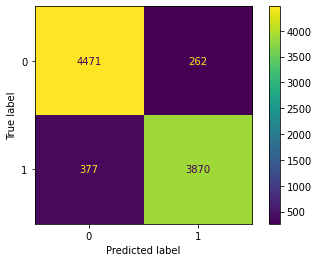

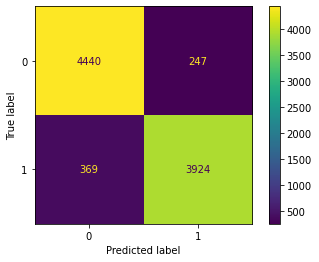

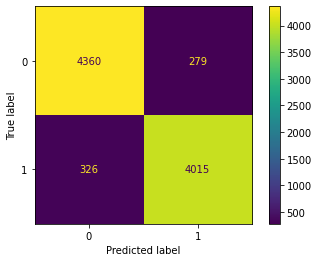

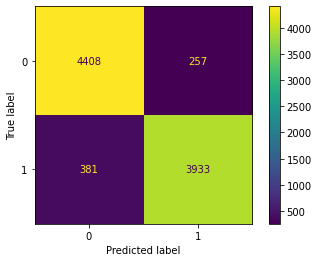

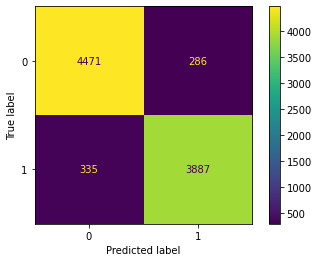

In [11]:
bayes_grid = {
    "vectorizer__min_df": [0.1, 0.01, 0.001],
    "vectorizer__max_df": [0.5, 0.7,0.9],
    "vectorizer__use_idf": [True, False],
    "bayes__alpha": [0.01, 0.1, 0.5, 1, 10],
    }
pipeline = Pipeline([("vectorizer", vectorizer), ("bayes", MultinomialNB())])
clf = GridSearchCV(pipeline, bayes_grid, cv=inner_cv, n_jobs=-1, verbose=4)
run = 1
accuracies = np.zeros(outer_splits)
f1s = np.zeros(outer_splits)
aucs = np.zeros(outer_splits)
precisions = np.zeros(outer_splits)
recalls = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts["text"]):
    print(f"CV run {run}")
    print("Get data")
    X_train, X_test = texts["text"][train_index], texts["text"][test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print("Perform Randomized Grid Search")
    clf.fit(X_train, y_train)
    print("Best model:")
    print("Accuracy: " + str(clf.best_score_))
    print(clf.best_params_)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average="binary")
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    accuracies[run-1] = accuracy
    f1s[run-1] = f1
    aucs[run-1] = auroc
    precisions[run-1] = precision
    recalls[run-1] = recall
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    print(f"Test precision: {precision}")
    print(f"Test recall: {recall}")
    cm = confusion_matrix(y_test, predictions, labels = clf.best_estimator_.classes_)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")
print(f"Mean f1: {f1}")
print(f"Mean AUC: {aucs.mean()}")
print(f"Mean precision: {precisions.mean()}")
print(f"Mean recall: {recalls.mean()}")

CV run 1
IDF: True
min df 0.001
max_df 0.5
C 1
gamma 0.01
Accuracy: 0.5195723592627652
gamma 0.1
Accuracy: 0.926889025001392
gamma 1
Accuracy: 0.9434266941366446
C 10
gamma 0.01
Accuracy: 0.9325129461551311
gamma 0.1
Accuracy: 0.9507210869202072
gamma 1
Accuracy: 0.9463221782950053
C 100
gamma 0.01
Accuracy: 0.9500528982682778
gamma 0.1
Accuracy: 0.9496631215546523
gamma 1
Accuracy: 0.9463221782950053
max_df 0.7
C 1
gamma 0.01
Accuracy: 0.5195723592627652
gamma 0.1
Accuracy: 0.9265549306754274
gamma 1
Accuracy: 0.9424244111587505
C 10
gamma 0.01
Accuracy: 0.9313992984019155
gamma 0.1
Accuracy: 0.9511108636338326
gamma 1
Accuracy: 0.9463221782950053
C 100
gamma 0.01
Accuracy: 0.9502756278189208
gamma 0.1
Accuracy: 0.9502199454312601
gamma 1
Accuracy: 0.9463221782950053
min df 0.01
max_df 0.5
C 1
gamma 0.01
Accuracy: 0.5251962804165042
gamma 0.1
Accuracy: 0.9298958739350743
gamma 1
Accuracy: 0.9432039645860014
C 10
gamma 0.01
Accuracy: 0.9334038643577036
gamma 0.1
Accuracy: 0.94537557770

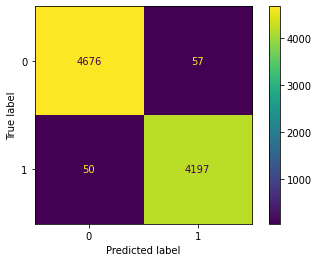

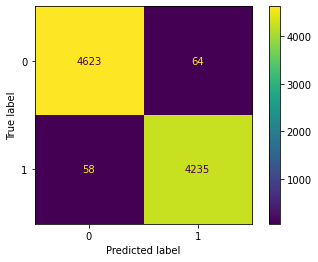

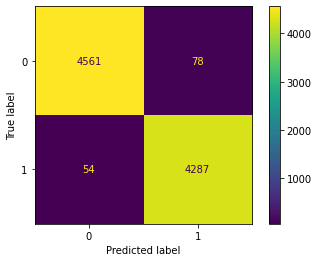

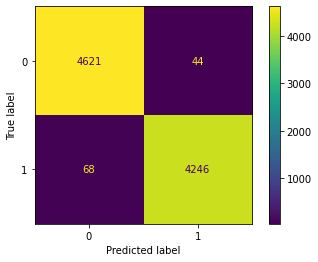

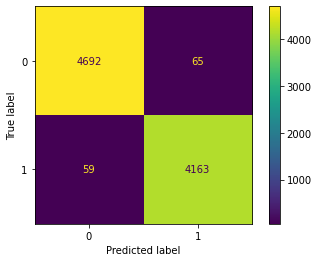

In [6]:
from sklearn.model_selection import train_test_split
run = 1
accuracies = np.zeros(outer_splits)
f1s = np.zeros(outer_splits)
aucs = np.zeros(outer_splits)
precisions = np.zeros(outer_splits)
recalls = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts):
    print(f"CV run {run}")
    train, test = texts.iloc[train_index], texts.iloc[test_index]
    grid_train, grid_test = train_test_split(train, test_size=0.5, shuffle=True)
    reduced_training = grid_train.iloc[0:2000]
    best_idf = False
    best_min_df = 0
    best_max_df = 0
    best_c = 0
    best_gamma = 0
    best_accuracy = 0
    for idf in [True, False]:
        print(f"IDF: {idf}")
        for min_df in [0.001, 0.01, 0.1]:
            print(f"min df {min_df}")
            for max_df in [0.5, 0.7]:
                print(f"max_df {max_df}")
                vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, use_idf=idf)
                grid_train_vectorized = vectorizer.fit_transform(reduced_training["text"])
                grid_test_vectorized = vectorizer.transform(grid_test["text"])
                for c in [1, 10, 100]:
                    print(f"C {c}")
                    for gamma in [.01, .1, 1]:
                        print(f"gamma {gamma}")
                        clf = SVC(C=c, gamma=gamma)
                        clf.fit(grid_train_vectorized, reduced_training["label"])
                        predictions = clf.predict(grid_test_vectorized)
                        accuracy = accuracy_score(grid_test["label"], predictions)
                        print(f"Accuracy: {accuracy}")
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_idf = idf
                            best_min_df = min_df
                            best_max_df = max_df
                            best_c = c
                            best_gamma = gamma
    # Refit the classifier
    print("Perform Grid Search")
    vectorizer = TfidfVectorizer(min_df=best_min_df, max_df=best_max_df, use_idf=best_idf)
    train_vectorized = vectorizer.fit_transform(train["text"])
    test_vectorized = vectorizer.transform(test["text"])
    print(f"Best model: idf {best_idf}, min_df {best_min_df}, max_df {best_max_df}, c {best_c}, gamma {best_gamma}")
    clf = SVC(C=best_c, gamma=best_gamma)
    clf.fit(train_vectorized, train["label"])
    predictions = clf.predict(test_vectorized)
    accuracy = accuracy_score(test["label"], predictions)
    f1 = f1_score(test["label"], predictions, average="binary")
    auroc = roc_auc_score(test["label"], predictions)
    precision = precision_score(test["label"], predictions)
    recall = recall_score(test["label"], predictions)
    accuracies[run-1] = accuracy
    f1s[run-1] = f1
    aucs[run-1] = auroc
    precisions[run-1] = precision
    recalls[run-1] = recall
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    print(f"Test precision: {precision}")
    print(f"Test recall: {recall}")
    cm = confusion_matrix(test["label"], predictions)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")
print(f"Mean f1: {f1}")
print(f"Mean AUC: {aucs.mean()}")
print(f"Mean precision: {precisions.mean()}")
print(f"Mean recall: {recalls.mean()}")

#### BERT

In [66]:
if method == "BERT":
    tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
    tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

    print(f'BERT model selected           : {tfhub_handle_encoder}')
    print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

    
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    #if "OSError: SavedModel file does not exist" occurs, navigate to the indicated folder and delete it
    
    text_test = texts
    text_preprocessed = bert_preprocess_model(text_test)

    #print(text_test)
    print(f'Keys       : {list(text_preprocessed.keys())}')
    print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
    print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
    print(f'Input Mask : {text_preprocessed["input_mask"]}')
    print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

#### DOC2Vec
Converting the document into vectors

In [8]:
import nltk
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [9]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

In [50]:
import multiprocessing
cores = multiprocessing.cpu_count()
run = 1
accuracies = np.zeros(outer_splits)
f1s = np.zeros(outer_splits)
aucs = np.zeros(outer_splits)
precisions = np.zeros(outer_splits)
recalls = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts):
    print(f"CV run {run}")
    outer_train = texts[["text", "label"]].iloc[train_index]
    outer_test = texts[["text", "label"]].iloc[test_index]
    best_accuracy = 0
    best_c = 0
    best_dimension = 0
    inner_train, inner_test = train_test_split(outer_train)
    for dimension in [50,500, 1000]:
        print(f"Dimension: {dimension}")
        model_dbow = Doc2Vec(dm=0, vector_size=dimension, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
        train_tagged = inner_train.apply(
            lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
        test_tagged = inner_test.apply(
            lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
        model_dbow.build_vocab([x for x in train_tagged.values])
        model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=30)
        inner_y_train, inner_X_train = vec_for_learning(model_dbow, train_tagged)
        inner_y_test, inner_X_test = vec_for_learning(model_dbow, test_tagged)
        for c in np.logspace(-3, 3, 6):
            print(f"C: {c}")
            clf = LogisticRegression(max_iter=10000, C=c)
            clf.fit(inner_X_train, inner_y_train)
            predictions = clf.predict(inner_X_test)
            accuracy = accuracy_score(inner_y_test, predictions)
            print(f"Model accuracy: {accuracy}")
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_c = c
                best_dimension = dimension
    model_dbow = Doc2Vec(dm=0, vector_size=best_dimension, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    train_tagged = outer_train.apply(
        lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
    test_tagged = outer_test.apply(
        lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=30)
    outer_y_train, outer_X_train = vec_for_learning(model_dbow, train_tagged)
    outer_y_test, outer_X_test = vec_for_learning(model_dbow, test_tagged)
    clf = LogisticRegression(max_iter=10000, C=best_c)
    clf.fit(outer_X_train, outer_y_train)
    predictions = clf.predict(outer_X_test)
    print(f"Best model: dimension {best_dimension}, c {best_c}")
    accuracy = accuracy_score(outer_y_test, predictions)
    f1 = f1_score(outer_y_test, predictions, average="binary")
    auroc = roc_auc_score(outer_y_test, predictions)
    precision = precision_score(outer_y_test, predictions)
    recall = recall_score(outer_y_test, predictions)
    accuracies[run-1] = accuracy
    f1s[run-1] = f1
    aucs[run-1] = auroc
    precisions[run-1] = precision
    recalls[run-1] = recall
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    print(f"Test precision: {precision}")
    print(f"Test recall: {recall}")
    cm = confusion_matrix(outer_y_test, predictions)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")
print(f"Mean f1: {f1}")
print(f"Mean AUC: {aucs.mean()}")
print(f"Mean precision: {precisions.mean()}")
print(f"Mean recall: {recalls.mean()}")

CV run 1
Dimension: 50
C: 0.001
Model accuracy: 0.9741648106904232
C: 0.015848931924611134
Model accuracy: 0.9780623608017818
C: 0.25118864315095796
Model accuracy: 0.9778396436525613
C: 3.981071705534969
Model accuracy: 0.977728285077951
C: 63.0957344480193
Model accuracy: 0.977728285077951
C: 1000.0
Model accuracy: 0.977728285077951
Dimension: 500
C: 0.001
Model accuracy: 0.9826280623608018
C: 0.015848931924611134
Model accuracy: 0.9870824053452116
C: 0.25118864315095796
Model accuracy: 0.9876391982182628
C: 3.981071705534969
Model accuracy: 0.9856347438752784
C: 63.0957344480193
Model accuracy: 0.9858574610244989
C: 1000.0
Model accuracy: 0.9859688195991091
Dimension: 1000
C: 0.001
Model accuracy: 0.9835189309576837
C: 0.015848931924611134
Model accuracy: 0.9878619153674832
C: 0.25118864315095796
Model accuracy: 0.9881959910913141
C: 3.981071705534969
Model accuracy: 0.9880846325167038
C: 63.0957344480193
Model accuracy: 0.9853006681514477
C: 1000.0
Model accuracy: 0.981403118040089

100%|██████████| 35918/35918 [00:00<00:00, 5130291.54it/s]


KeyboardInterrupt: 

CV run 1
Dimension: 50
Alpha: 0.01
Model accuracy: 0.9140311804008908
Alpha: 0.1
Model accuracy: 0.9140311804008908
Alpha: 0.5
Model accuracy: 0.9140311804008908
Alpha: 1
Model accuracy: 0.9140311804008908
Alpha: 10
Model accuracy: 0.9141425389755011
Dimension: 200
Alpha: 0.01
Model accuracy: 0.955011135857461
Alpha: 0.1
Model accuracy: 0.955011135857461
Alpha: 0.5
Model accuracy: 0.955011135857461
Alpha: 1
Model accuracy: 0.955011135857461
Alpha: 10
Model accuracy: 0.9548997772828508
Dimension: 500
Alpha: 0.01
Model accuracy: 0.9612472160356348
Alpha: 0.1
Model accuracy: 0.9612472160356348
Alpha: 0.5
Model accuracy: 0.9612472160356348
Alpha: 1
Model accuracy: 0.9612472160356348
Alpha: 10
Model accuracy: 0.9612472160356348
Dimension: 1000
Alpha: 0.01
Model accuracy: 0.9697104677060133
Alpha: 0.1
Model accuracy: 0.9697104677060133
Alpha: 0.5
Model accuracy: 0.9697104677060133
Alpha: 1
Model accuracy: 0.9697104677060133
Alpha: 10
Model accuracy: 0.9697104677060133


100%|██████████| 35918/35918 [00:00<00:00, 5985340.13it/s]


Best model: dimension 1000, c 10
Test Accuracy: 0.9643652561247216
Test F1: 0.9620763214031761
Test AUC: 0.9639220854670734
Test precision: 0.968503937007874
Test recall: 0.9557334589121733
[[4601  132]
 [ 188 4059]]
CV run 2
Dimension: 50
Alpha: 0.01
Model accuracy: 0.9130289532293987
Alpha: 0.1
Model accuracy: 0.9130289532293987
Alpha: 0.5
Model accuracy: 0.9130289532293987
Alpha: 1
Model accuracy: 0.9130289532293987
Alpha: 10
Model accuracy: 0.9129175946547884
Dimension: 200
Alpha: 0.01
Model accuracy: 0.9501113585746103
Alpha: 0.1
Model accuracy: 0.9501113585746103
Alpha: 0.5
Model accuracy: 0.9501113585746103
Alpha: 1
Model accuracy: 0.9501113585746103
Alpha: 10
Model accuracy: 0.9502227171492205
Dimension: 500
Alpha: 0.01
Model accuracy: 0.9644766146993319
Alpha: 0.1
Model accuracy: 0.9644766146993319
Alpha: 0.5
Model accuracy: 0.9644766146993319
Alpha: 1
Model accuracy: 0.9644766146993319
Alpha: 10
Model accuracy: 0.9644766146993319
Dimension: 1000
Alpha: 0.01
Model accuracy: 0.

100%|██████████| 35918/35918 [00:00<00:00, 5985815.76it/s]


Best model: dimension 1000, c 10
Test Accuracy: 0.9661469933184855
Test F1: 0.9644111449309296
Test AUC: 0.9658663054969983
Test precision: 0.9694045657801835
Test recall: 0.9594689028651293
[[4557  130]
 [ 174 4119]]
CV run 3
Dimension: 50
Alpha: 0.01
Model accuracy: 0.9223830734966593
Alpha: 0.1
Model accuracy: 0.9223830734966593
Alpha: 0.5
Model accuracy: 0.9223830734966593
Alpha: 1
Model accuracy: 0.9223830734966593
Alpha: 10
Model accuracy: 0.9223830734966593
Dimension: 200
Alpha: 0.01
Model accuracy: 0.9521158129175946
Alpha: 0.1
Model accuracy: 0.9521158129175946
Alpha: 0.5
Model accuracy: 0.9521158129175946
Alpha: 1
Model accuracy: 0.9521158129175946
Alpha: 10
Model accuracy: 0.9521158129175946
Dimension: 500
Alpha: 0.01
Model accuracy: 0.9620267260579065
Alpha: 0.1
Model accuracy: 0.9620267260579065
Alpha: 0.5
Model accuracy: 0.9620267260579065
Alpha: 1
Model accuracy: 0.9620267260579065
Alpha: 10
Model accuracy: 0.9621380846325167
Dimension: 1000
Alpha: 0.01
Model accuracy: 0

100%|██████████| 35918/35918 [00:00<00:00, 5935348.32it/s]


Best model: dimension 1000, c 10
Test Accuracy: 0.9688195991091314
Test F1: 0.9677270631627478
Test AUC: 0.9687630273644734
Test precision: 0.9683967704728951
Test recall: 0.967058281501958
[[4502  137]
 [ 143 4198]]
CV run 4
Dimension: 50
Alpha: 0.01
Model accuracy: 0.8982182628062361
Alpha: 0.1
Model accuracy: 0.8982182628062361
Alpha: 0.5
Model accuracy: 0.8982182628062361
Alpha: 1
Model accuracy: 0.8982182628062361
Alpha: 10
Model accuracy: 0.8983296213808464
Dimension: 200
Alpha: 0.01
Model accuracy: 0.9503340757238308
Alpha: 0.1
Model accuracy: 0.9503340757238308
Alpha: 0.5
Model accuracy: 0.9503340757238308
Alpha: 1
Model accuracy: 0.9503340757238308
Alpha: 10
Model accuracy: 0.9503340757238308
Dimension: 500
Alpha: 0.01
Model accuracy: 0.9603563474387528
Alpha: 0.1
Model accuracy: 0.9603563474387528
Alpha: 0.5
Model accuracy: 0.9603563474387528
Alpha: 1
Model accuracy: 0.9603563474387528
Alpha: 10
Model accuracy: 0.9603563474387528
Dimension: 1000
Alpha: 0.01
Model accuracy: 0.

100%|██████████| 35919/35919 [00:00<00:00, 5815456.09it/s]


Best model: dimension 1000, c 10
Test Accuracy: 0.967479674796748
Test F1: 0.9657518179685668
Test AUC: 0.9669851541455546
Test precision: 0.9774453941120608
Test recall: 0.9543347241539175
[[4570   95]
 [ 197 4117]]
CV run 5
Dimension: 50
Alpha: 0.01
Model accuracy: 0.9300668151447662
Alpha: 0.1
Model accuracy: 0.9300668151447662
Alpha: 0.5
Model accuracy: 0.9300668151447662
Alpha: 1
Model accuracy: 0.9300668151447662
Alpha: 10
Model accuracy: 0.9300668151447662
Dimension: 200
Alpha: 0.01
Model accuracy: 0.9542316258351893
Alpha: 0.1
Model accuracy: 0.9542316258351893
Alpha: 0.5
Model accuracy: 0.9542316258351893
Alpha: 1
Model accuracy: 0.9542316258351893
Alpha: 10
Model accuracy: 0.9542316258351893
Dimension: 500
Alpha: 0.01
Model accuracy: 0.9628062360801781
Alpha: 0.1
Model accuracy: 0.9628062360801781
Alpha: 0.5
Model accuracy: 0.9628062360801781
Alpha: 1
Model accuracy: 0.9628062360801781
Alpha: 10
Model accuracy: 0.9628062360801781
Dimension: 1000
Alpha: 0.01
Model accuracy: 0.

100%|██████████| 35919/35919 [00:00<00:00, 5129910.29it/s]


Best model: dimension 1000, c 10
Test Accuracy: 0.9665887069829603
Test F1: 0.964336661911555
Test AUC: 0.9662565635404088
Test precision: 0.968019093078759
Test recall: 0.9606821411653245
[[4623  134]
 [ 166 4056]]
[0.96436526 0.96614699 0.9688196  0.96747967 0.96658871]
Mean accuracy: 0.9666800460664093
Mean f1: 0.964336661911555
Mean AUC: 0.9663586272029017
Mean precision: 0.9703539520903546
Mean recall: 0.9594555017197004


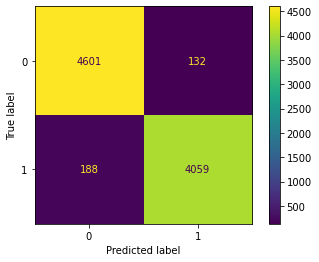

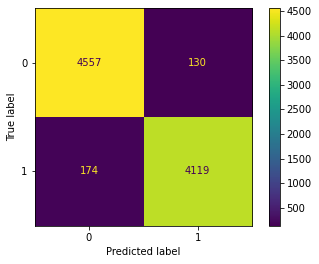

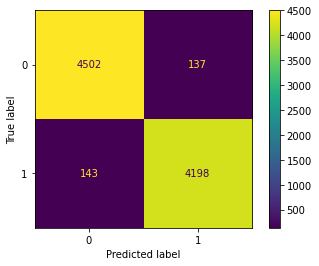

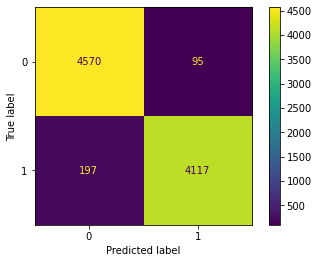

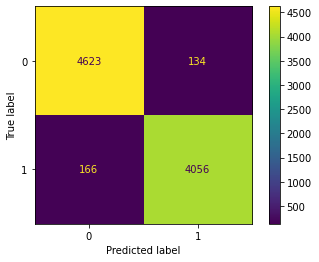

In [16]:
import multiprocessing
from sklearn.preprocessing import MinMaxScaler
cores = multiprocessing.cpu_count()
run = 1
accuracies = np.zeros(outer_splits)
f1s = np.zeros(outer_splits)
aucs = np.zeros(outer_splits)
precisions = np.zeros(outer_splits)
recalls = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts):
    print(f"CV run {run}")
    outer_train = texts[["text", "label"]].iloc[train_index]
    outer_test = texts[["text", "label"]].iloc[test_index]
    best_accuracy = 0
    best_alpha = 0
    best_dimension = 0
    inner_train, inner_test = train_test_split(outer_train)
    for dimension in [50, 200, 500, 1000]:
        print(f"Dimension: {dimension}")
        model_dbow = Doc2Vec(dm=0, vector_size=dimension, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
        train_tagged = inner_train.apply(
            lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
        test_tagged = inner_test.apply(
            lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
        model_dbow.build_vocab([x for x in train_tagged.values])
        model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=30)
        inner_y_train, inner_X_train = vec_for_learning(model_dbow, train_tagged)
        inner_y_test, inner_X_test = vec_for_learning(model_dbow, test_tagged)
        scaler = MinMaxScaler()
        inner_X_train_scaled = scaler.fit_transform(inner_X_train)
        inner_X_test_scaled = scaler.transform(inner_X_test)
        for alpha in [0.01, 0.1, 0.5, 1, 10]:
            print(f"Alpha: {alpha}")
            clf = MultinomialNB(alpha = alpha)
            clf.fit(inner_X_train_scaled, inner_y_train)
            predictions = clf.predict(inner_X_test_scaled)
            accuracy = accuracy_score(inner_y_test, predictions)
            print(f"Model accuracy: {accuracy}")
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_alpha = alpha
                best_dimension = dimension
    model_dbow = Doc2Vec(dm=0, vector_size=best_dimension, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    train_tagged = outer_train.apply(
        lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
    test_tagged = outer_test.apply(
        lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=30)
    outer_y_train, outer_X_train = vec_for_learning(model_dbow, train_tagged)
    outer_y_test, outer_X_test = vec_for_learning(model_dbow, test_tagged)
    scaler = MinMaxScaler()
    outer_X_train_scaled = scaler.fit_transform(outer_X_train)
    outer_X_test_scaled = scaler.transform(outer_X_test)
    clf = MultinomialNB(alpha=best_alpha)
    clf.fit(outer_X_train_scaled, outer_y_train)
    predictions = clf.predict(outer_X_test_scaled)
    print(f"Best model: dimension {best_dimension}, c {best_c}")
    accuracy = accuracy_score(outer_y_test, predictions)
    f1 = f1_score(outer_y_test, predictions, average="binary")
    auroc = roc_auc_score(outer_y_test, predictions)
    precision = precision_score(outer_y_test, predictions)
    recall = recall_score(outer_y_test, predictions)
    accuracies[run-1] = accuracy
    f1s[run-1] = f1
    aucs[run-1] = auroc
    precisions[run-1] = precision
    recalls[run-1] = recall
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    print(f"Test precision: {precision}")
    print(f"Test recall: {recall}")
    cm = confusion_matrix(outer_y_test, predictions)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")
print(f"Mean f1: {f1}")
print(f"Mean AUC: {aucs.mean()}")
print(f"Mean precision: {precisions.mean()}")
print(f"Mean recall: {recalls.mean()}")

CV run 1
Dimension: 50
C 1
gamma 0.01
Accuracy: 0.9754999767992204
gamma 0.1
Accuracy: 0.9793977077629809
gamma 1
Accuracy: 0.7063709340633846
C 10
gamma 0.01
Accuracy: 0.9780984641083941
gamma 0.1
Accuracy: 0.97666001577653
gamma 1
Accuracy: 0.7328198227460443
C 100
gamma 0.01
Accuracy: 0.9768456220128996
gamma 0.1
Accuracy: 0.9733191035218783
gamma 1
Accuracy: 0.7328198227460443
Dimension: 200
C 1
gamma 0.01
Accuracy: 0.9845482808222357
gamma 0.1
Accuracy: 0.98580112291773
gamma 1
Accuracy: 0.6006217808918379
C 10
gamma 0.01
Accuracy: 0.9864043431859311
gamma 0.1
Accuracy: 0.9856155166813605
gamma 1
Accuracy: 0.602663449491903
C 100
gamma 0.01
Accuracy: 0.9834346434040184
gamma 0.1
Accuracy: 0.9829706278130945
gamma 1
Accuracy: 0.602663449491903
Dimension: 500
C 1
gamma 0.01
Accuracy: 0.9847338870586052
gamma 0.1
Accuracy: 0.9844554777040508
gamma 1
Accuracy: 0.5963992390144309
C 10
gamma 0.01
Accuracy: 0.9855691151222681
gamma 0.1
Accuracy: 0.9837130527585727
gamma 1
Accuracy: 0.598

100%|██████████| 35918/35918 [00:00<00:00, 5047442.32it/s]


Best model: dimension 1000, c 10, gamma 0.01
Test Accuracy: 0.9899777282850779
Test F1: 0.9893692416725727
Test AUC: 0.9897790419018389
Test precision: 0.9926522872718654
Test recall: 0.9861078408288203
[[4702   31]
 [  59 4188]]
CV run 2
Dimension: 50
C 1
gamma 0.01
Accuracy: 0.9719270567491067
gamma 0.1
Accuracy: 0.9761031970674214
gamma 1
Accuracy: 0.6881815228991695
C 10
gamma 0.01
Accuracy: 0.9747111502946499
gamma 0.1
Accuracy: 0.9735975128764327
gamma 1
Accuracy: 0.7139807897545357
C 100
gamma 0.01
Accuracy: 0.973040694167324
gamma 0.1
Accuracy: 0.9684469398171779
gamma 1
Accuracy: 0.7139807897545357
Dimension: 200
C 1
gamma 0.01
Accuracy: 0.9852443042086214
gamma 0.1
Accuracy: 0.9857547213586376
gamma 1
Accuracy: 0.6055867477147232
C 10
gamma 0.01
Accuracy: 0.9851515010904366
gamma 0.1
Accuracy: 0.9850122964131595
gamma 1
Accuracy: 0.6076284163147881
C 100
gamma 0.01
Accuracy: 0.9820425966312468
gamma 0.1
Accuracy: 0.9846874854995128
gamma 1
Accuracy: 0.6076284163147881
Dimensi

100%|██████████| 35918/35918 [00:00<00:00, 5984389.09it/s]


Best model: dimension 1000, c 1, gamma 0.01
Test Accuracy: 0.9909799554565701
Test F1: 0.9905561385099686
Test AUC: 0.9909185002095541
Test precision: 0.9915966386554622
Test recall: 0.989517819706499
[[4651   36]
 [  45 4248]]
CV run 3
Dimension: 50
C 1
gamma 0.01
Accuracy: 0.9721126629854763
gamma 0.1
Accuracy: 0.9768456220128996
gamma 1
Accuracy: 0.6823349264535289
C 10
gamma 0.01
Accuracy: 0.9757319845946824
gamma 0.1
Accuracy: 0.9767064173356225
gamma 1
Accuracy: 0.7047932810542434
C 100
gamma 0.01
Accuracy: 0.9764744095401605
gamma 0.1
Accuracy: 0.9732263004036935
gamma 1
Accuracy: 0.7047932810542434
Dimension: 200
C 1
gamma 0.01
Accuracy: 0.983991462113127
gamma 0.1
Accuracy: 0.983388241844926
gamma 1
Accuracy: 0.607489211637511
C 10
gamma 0.01
Accuracy: 0.9850122964131595
gamma 0.1
Accuracy: 0.9838058558767575
gamma 1
Accuracy: 0.6096236833557608
C 100
gamma 0.01
Accuracy: 0.980372140503921
gamma 0.1
Accuracy: 0.9838522574358498
gamma 1
Accuracy: 0.6096236833557608
Dimension: 5

100%|██████████| 35918/35918 [00:00<00:00, 5985340.13it/s]


Best model: dimension 1000, c 1, gamma 0.01
Test Accuracy: 0.9904231625835189
Test F1: 0.9900944482838056
Test AUC: 0.9904126046118317
Test precision: 0.9900944482838056
Test recall: 0.9900944482838056
[[4596   43]
 [  43 4298]]
CV run 4
Dimension: 50
C 1
gamma 0.01
Accuracy: 0.9722995545657016
gamma 0.1
Accuracy: 0.9773106904231625
gamma 1
Accuracy: 0.7420193021529324
C 10
gamma 0.01
Accuracy: 0.9748051224944321
gamma 0.1
Accuracy: 0.9757331106161841
gamma 1
Accuracy: 0.7701837416481069
C 100
gamma 0.01
Accuracy: 0.9745731254639941
gamma 0.1
Accuracy: 0.9700723830734966
gamma 1
Accuracy: 0.7701837416481069
Dimension: 200
C 1
gamma 0.01
Accuracy: 0.9842242019302153
gamma 0.1
Accuracy: 0.9857553823311062
gamma 1
Accuracy: 0.5923812175204157
C 10
gamma 0.01
Accuracy: 0.9855233853006682
gamma 0.1
Accuracy: 0.9855697847067557
gamma 1
Accuracy: 0.5949331848552338
C 100
gamma 0.01
Accuracy: 0.9826466221232368
gamma 0.1
Accuracy: 0.9851985894580549
gamma 1
Accuracy: 0.5949331848552338
Dimensi

100%|██████████| 35919/35919 [00:00<00:00, 5985268.98it/s]


Best model: dimension 1000, c 1, gamma 0.01
Test Accuracy: 0.9919812896759105
Test F1: 0.991635687732342
Test AUC: 0.991881811554991
Test precision: 0.9939450395901258
Test recall: 0.9893370421882244
[[4639   26]
 [  46 4268]]
CV run 5
Dimension: 50
C 1
gamma 0.01
Accuracy: 0.9709539717891611
gamma 0.1
Accuracy: 0.9769858945805494
gamma 1
Accuracy: 0.6967334818114328
C 10
gamma 0.01
Accuracy: 0.9744803266518188
gamma 0.1
Accuracy: 0.9753155159613957
gamma 1
Accuracy: 0.7213251670378619
C 100
gamma 0.01
Accuracy: 0.9735523385300668
gamma 0.1
Accuracy: 0.9714643652561247
gamma 1
Accuracy: 0.7213251670378619
Dimension: 200
C 1
gamma 0.01
Accuracy: 0.9848737936154417
gamma 0.1
Accuracy: 0.9863121752041574
gamma 1
Accuracy: 0.6046306607275427
C 10
gamma 0.01
Accuracy: 0.9867761692650334
gamma 0.1
Accuracy: 0.9864977728285078
gamma 1
Accuracy: 0.607507423904974
C 100
gamma 0.01
Accuracy: 0.9823218262806236
gamma 0.1
Accuracy: 0.986358574610245
gamma 1
Accuracy: 0.607507423904974
Dimension: 5

100%|██████████| 35919/35919 [00:00<00:00, 5129735.62it/s]


Best model: dimension 200, c 10, gamma 0.01
Test Accuracy: 0.9903107250250585
Test F1: 0.9897004853794247
Test AUC: 0.9902961822349213
Test precision: 0.9893491124260355
Test recall: 0.9900521080056846
[[4712   45]
 [  42 4180]]
[0.98997773 0.99097996 0.99042316 0.99198129 0.99031073]
Mean accuracy: 0.9907345722052272
Mean f1: 0.9897004853794247
Mean AUC: 0.9906576281026274
Mean precision: 0.991527505245459
Mean recall: 0.9890218518026067


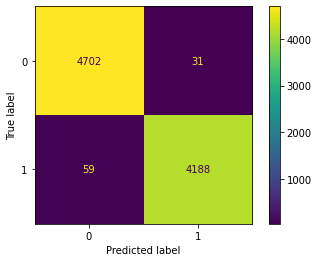

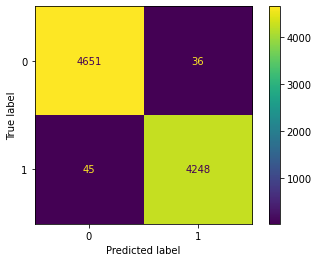

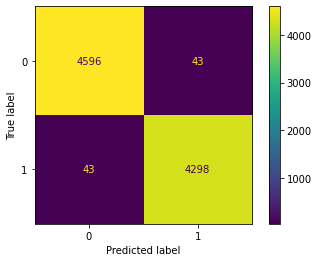

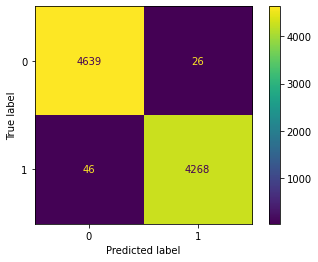

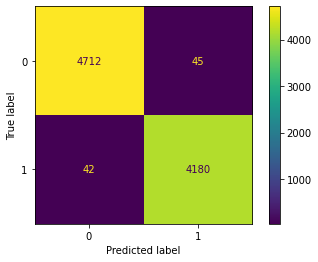

In [25]:
import multiprocessing
cores = multiprocessing.cpu_count()
run = 1
accuracies = np.zeros(outer_splits)
f1s = np.zeros(outer_splits)
aucs = np.zeros(outer_splits)
precisions = np.zeros(outer_splits)
recalls = np.zeros(outer_splits)
for train_index, test_index in outer_cv.split(texts):
    print(f"CV run {run}")
    outer_train = texts[["text", "label"]].iloc[train_index]
    outer_test = texts[["text", "label"]].iloc[test_index]
    best_accuracy = 0
    best_c = 0
    best_gamma = 0
    best_dimension = 0
    inner_train, inner_test = train_test_split(outer_train, test_size=0.6)
    for dimension in [50, 200, 500, 1000]:
        print(f"Dimension: {dimension}")
        model_dbow = Doc2Vec(dm=0, vector_size=dimension, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
        train_tagged = inner_train.apply(
            lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
        test_tagged = inner_test.apply(
            lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
        model_dbow.build_vocab([x for x in train_tagged.values])
        model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=30)
        inner_y_train, inner_X_train = vec_for_learning(model_dbow, train_tagged)
        inner_y_test, inner_X_test = vec_for_learning(model_dbow, test_tagged)
        for c in [1, 10, 100]:
            print(f"C {c}")
            for gamma in [.01, .1, 1]:
                print(f"gamma {gamma}")
                clf = SVC(C=c, gamma=gamma)
                clf.fit(inner_X_train, inner_y_train)
                predictions = clf.predict(inner_X_test)
                accuracy = accuracy_score(inner_y_test, predictions)
                print(f"Accuracy: {accuracy}")
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_dimension = dimension
                    best_c = c
                    best_gamma = gamma
    model_dbow = Doc2Vec(dm=0, vector_size=best_dimension, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    train_tagged = outer_train.apply(
        lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
    test_tagged = outer_test.apply(
        lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=30)
    outer_y_train, outer_X_train = vec_for_learning(model_dbow, train_tagged)
    outer_y_test, outer_X_test = vec_for_learning(model_dbow, test_tagged)
    clf = SVC(C=best_c, gamma=best_gamma)
    clf.fit(outer_X_train, outer_y_train)
    predictions = clf.predict(outer_X_test)
    print(f"Best model: dimension {best_dimension}, c {best_c}, gamma {best_gamma}")
    accuracy = accuracy_score(outer_y_test, predictions)
    f1 = f1_score(outer_y_test, predictions, average="binary")
    auroc = roc_auc_score(outer_y_test, predictions)
    precision = precision_score(outer_y_test, predictions)
    recall = recall_score(outer_y_test, predictions)
    accuracies[run-1] = accuracy
    f1s[run-1] = f1
    aucs[run-1] = auroc
    precisions[run-1] = precision
    recalls[run-1] = recall
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test AUC: {auroc}")
    print(f"Test precision: {precision}")
    print(f"Test recall: {recall}")
    cm = confusion_matrix(outer_y_test, predictions)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("Confusion Matrix Run " + str(run))
    run += 1
print(accuracies)
print(f"Mean accuracy: {accuracies.mean()}")
print(f"Mean f1: {f1}")
print(f"Mean AUC: {aucs.mean()}")
print(f"Mean precision: {precisions.mean()}")
print(f"Mean recall: {recalls.mean()}")

# Store Results

In [11]:
if method == "BERT":
    a_file = open("bert_preprocessed.pkl", "wb")
    pickle.dump(text_preprocessed, a_file)
    a_file.close()
    np.save("training_labels", labels)